In [8]:
from src.Funciones import *
from matplotlib.patches import Polygon

In [32]:
def buscaEsquina(m, j, e1, e2):
    '''
    **Función auxiliar para calVerticesFBZ
    Indica con qué 'fila' de la matriz en que se opera se va a intercambiar.
    m  -> Matríz en que operamos
    j  -> Columna que estamos iterando
    e1 -> Primera dimención de la base actual
    e2 -> Segunda dimención de la base actual
    '''
    ind = -1
    val = (10.0)**300
    for i in range(8):
        if not(i==e1 or i==e2):
            if (m[i][j]>0):
                c = m[i][10]/m[i][j]
                if c < val:
                    val = c
                    ind = i
    return ind

def opera(m,e,s):
    '''
    **Función auxiliar para calVerticesFBZ
    Opera en la matríz para dejar en la columna 'e' tengamos ceros eccepto en m[s][e] donde tenemos 1
    m -> Matríz que operamos
    e -> Columna de la celda pivote
    s -> Fila de la celda pivote
    '''
    m[s] = m[s]/(m[s][e])
    for i in range(8):
        if i!=s:
            piv=m[i][e]
            m[i] = m[i]-(m[s]*piv)

def pmat(m):
    '''
    **Función auxiliar para calVerticesFBZ
    Imprime en pantalla el estado actual de la matriz m.
    '''
    for i in range(len(m)):
        lin = ""
        for j in range(len(m[0])):
            lin = lin+"\t"+str(round(m[i][j],2))
        print(lin)
    print("")
    
def calcVerticesFBZ(b1, b2):
    '''
    Calcula la posición de los vertices frontera de la FBZ a partir de los vectores reciprocos a* y b*
    proyectados en el plano XY.
    b1 -> Vector reciproco a* de la red
    b2 -> Vector reciproco b* de la red
    '''
    pts = []
    vecinos=[m2V(b1,b2,( 1, 0)),m2V(b1,b2,( 1, 1)),
             m2V(b1,b2,( 0, 1)),m2V(b1,b2,(-1, 1)),
             m2V(b1,b2,(-1, 0)),m2V(b1,b2,(-1,-1)),
             m2V(b1,b2,( 0,-1)),m2V(b1,b2,( 1,-1))]
    # Creamos el espacio para la matriz en que operaremos
    v = np.array(vecinos)
    eq = np.zeros((8,11))
    et = ["V1","V2","V3","V4","V5","V6","V7","V8"]
    xy = [10,10]
    cruce = [-1,-1]
    # Damos los valores correspondientes
    for i in range(8):
        eq[i][i] = 1
        eq[i][8] = 2*v[i][0]
        eq[i][9] = 2*v[i][1]
        eq[i][10] = (v[i][0]**2) + (v[i][1]**2)
    #pmat(eq) #---Imprime la matriz para hacer seguimiento
    # Entra valor de X
    ind = buscaEsquina(eq,8,xy[0],xy[1])
    xy[0]=ind
    cruce[0]=ind
    opera(eq,8,ind)
    # Entra valor de Y
    ind = buscaEsquina(eq,9,xy[0],xy[1])
    xy[1]=ind
    cruce[1]=ind
    opera(eq,9,ind)
    p = (round(eq[xy[0]][10],10),round(eq[xy[1]][10],10))
    pts.append(p)
    #pmat(eq) #---Imprime la matriz para hacer seguimiento
    cont=0
    while True:
        cont+=1
        e = cruce[0]
        s = buscaEsquina(eq,e,xy[0],xy[1])
        opera(eq,e,s)
        #pmat(eq) #---Imprime la matriz para hacer seguimiento
        cruce[0] = cruce[1]
        cruce[1] = s
        p2 = (round(eq[xy[0]][10],10),round(eq[xy[1]][10],10))
        if p2!=p:
            if p2==pts[0]:
                break
            p=p2
            pts.append(p)
        if cont>10:
            break
    
    return pts, eq

def reciprocalBackgroundMesh(l,vl,t):
    '''
    Calcula los puntos de Red de la red reciproca y la maya formada por las FBZ de estos.
    Regresa 2 listas con las posiciones X y Y de los puntos y una 'colección' de lineas usadas por
    'Polygon' para cargar un poligono en pabtalla usando la función 'add_patch'.
    l  -> Red para la que se lleva a cabo la operación
    vl -> Vertices de la FBZ asociada a esta red
    t  -> Tamaño con el que se pintarán las lineas.
    '''
    xs = []
    ys = []
    enls=[]
    sra, srb = to2D(l.reciprocalVectors[0]), to2D(l.reciprocalVectors[1])
    for i in range(-10,10):
        for j in range(-10,10):
            (px,py) = m2V(sra,srb,(i,j))
            #Calcula la posición de cada centro
            xs.append(px)
            ys.append(py)
            o = sumaV((px,py),vl[len(vl)-1])
            for p in vl:#calcula las aristas de la FBZ de cada centro
                f = sumaV((px,py), p)
                enls.append([o, f])
                o = f
    xs = np.array(xs)
    ys = np.array(ys)
    linkList = mc.LineCollection(np.array(enls), colors='silver', linewidths=(t/10))
    return xs, ys, linkList

def printReciprocalSpace(sl, lol, t=10, border=1.0):
    '''
    Imprime en pantalla la FBZ de la red en el espacio reciproco, si esta red pertenece a un sistema multicapa
    imprime tambien la FBZ de cada capa.
    t      -> Valor con el que se determinarán los tamaños con el que se dibujarán puntos y líneas.
    border -> Límites de la gráfica dibujada.
    '''
    print("Calculando...")
    ax = plt.subplot()
    if len(lol) > 0: #"Pintamos" la FBZ de cada capa que forma la red si es que es un sistema multicapa
        colors=['#'+''.join([random.choice('3456789') for i in range(6)]) for j in range(len(lol))]
        for i in range(len(lol)):
            vl, eq = calcVerticesFBZ(to2D(lol[i].reciprocalVectors[0]),to2D(lol[i].reciprocalVectors[1]))
            fbzLayer = Polygon(vl, alpha=0.4, color = colors[i], label = lol[i].name)
            ax.add_patch(fbzLayer)
            print("...Pintando capa {}".format(i+1))
    
    vl, eq = calcVerticesFBZ(to2D(sl.reciprocalVectors[0]),to2D(sl.reciprocalVectors[1]))
    xs, ys, linkList = reciprocalBackgroundMesh(sl,vl,t)
    fbzRed = Polygon(vl, alpha=0.7, color = 'gray', label = sl.name)
    ax.add_patch(fbzRed) #"Pntamos" la FBZ de la red
    
    ax.add_collection(linkList)#"Pintamos" los enlaces de la red de fondo calculado previamente
    ax.scatter(xs,ys, color='black',s=t)#"Pintamos" los centros de la red de fondo calculados previamente 
    ax.set(xlim=(-border,border), ylim=(-border,border))
    ax.legend(loc = 'upper right')
    print("...Terminado")
    plt.show()


In [6]:
grafeno=hexa3(2.462,name='Grafeno').mRot(-90)
rect=Red((4.267,0.0),(0.0,4.914),atms=[Atomo((0.0,0.0),sig='X')],name='Rect',enls=[((0.0,0.0),(1.0,0.0)),((0.0,0.0),(0.0,1.0))])

In [98]:
grafeno=hexa6(2.462,name='Grafeno')

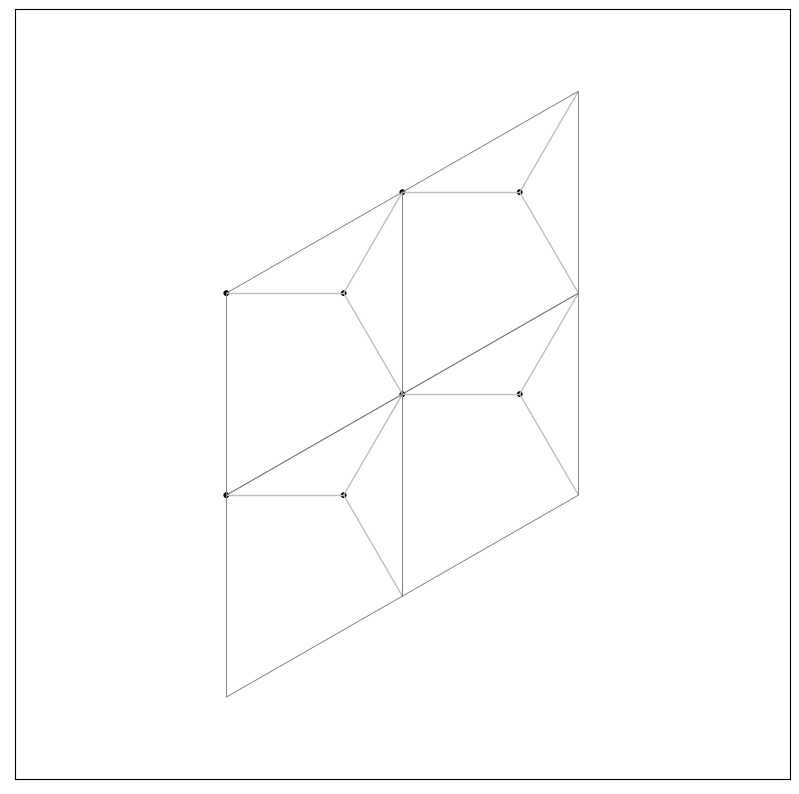

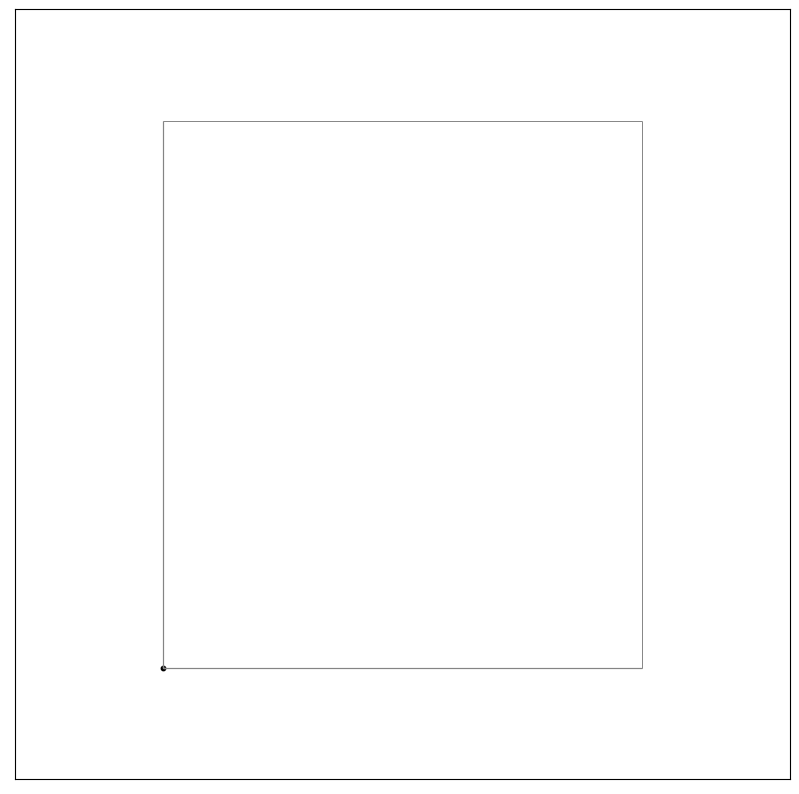

In [7]:
grafeno.showXY(2,2)
rect.showme()

In [33]:
calculaPares(grafeno,rect,eps=0.1)

([[[[2, 0], [0, -1], 1.0020350020350022, 0.010000000000000675],
   [[1, -2], [-1, -1], 1.0008899777265872, 0.010355723351332367],
   [[0, -4], [-2, -1], 1.0000337807913402, 0.011356232848846844],
   [[4, 0], [0, -2], 1.0020350020350022, 0.02000000000000135],
   [[3, -2], [-1, -2], 1.0016126939206595, 0.020180213233002002],
   [[2, -4], [-2, -2], 1.0008899777265872, 0.020711446702664733],
   [[6, 0], [0, -3], 1.0020350020350022, 0.030000000000002913],
   [[1, -6], [-3, -2], 1.0003587440198747, 0.021567778169385744],
   [[5, -2], [-1, -3], 1.0018291954704177, 0.030120441665577858],
   [[0, -8], [-4, -2], 1.0000337807913402, 0.02271246569769369],
   [[4, -4], [-2, -3], 1.0013665939641867, 0.030478911143893766],
   [[8, 0], [0, -4], 1.0020350020350022, 0.0400000000000027],
   [[3, -6], [-3, -3], 1.000889977726587, 0.03106717005399562],
   [[7, -2], [-1, -4], 1.0019151887587243, 0.04009041040111114],
   [[2, -8], [-4, -3], 1.0005091743506453, 0.0318724975185341],
   [[6, -4], [-2, -4], 1.00

In [9]:
sb=(m2V(grafeno.a,grafeno.b,(2,0)))
sb2=(m2V(rect.a,rect.b,(0,-1)))
sa=(m2V(grafeno.a,grafeno.b,(1,2)))
sa2=(m2V(rect.a,rect.b,(1,0)))
dist(sa,sa2),dist(sb,sb2)

(0.002690911765424353, 0.010000000000000675)

In [34]:
sr.exporta()

1

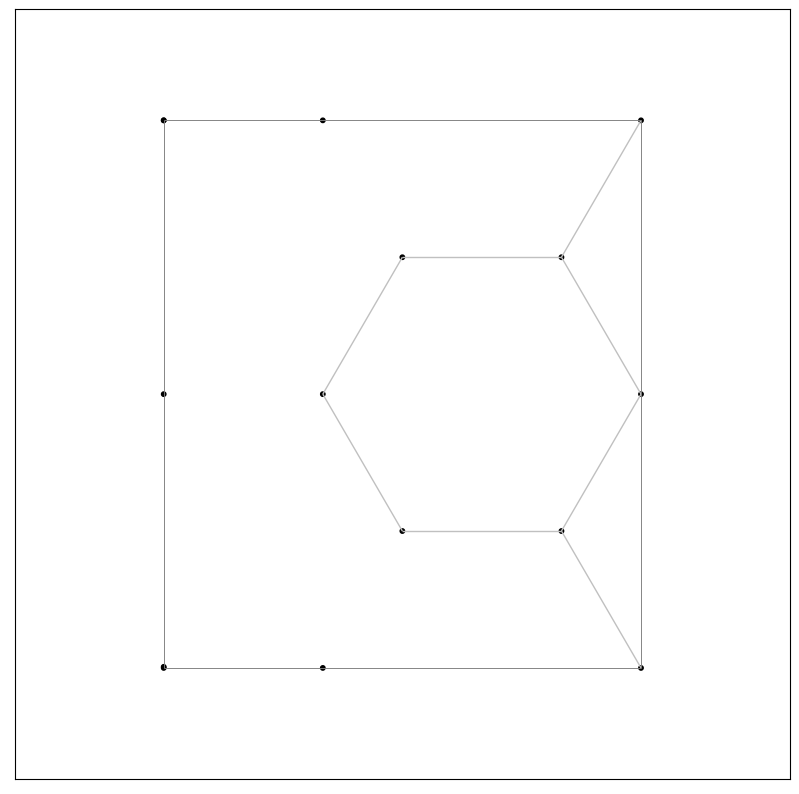

In [11]:
sr=superMesh(sa,sb,[grafeno,rect])
sr.showme()

In [5]:
m1=g1
a, eq=calcVerticesFBZ(to2D(m1.reciprocalVectors[0]),to2D(m1.reciprocalVectors[1]))

	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	2.71	1.56	2.45
	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	2.71	-1.56	2.45
	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	-3.13	2.45
	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	-2.71	-4.69	7.35
	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	-2.71	-1.56	2.45
	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	-2.71	1.56	2.45
	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	3.13	2.45
	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	2.71	4.69	7.35

	0.37	0.0	0.0	0.0	0.0	0.0	-0.18	0.0	1.0	0.0	0.45
	-1.0	1.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	2.45
	0.0	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	4.9
	1.0	0.0	0.0	1.0	0.0	0.0	1.0	0.0	0.0	0.0	12.25
	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	4.9
	1.0	0.0	0.0	0.0	0.0	1.0	-1.0	0.0	0.0	0.0	2.45
	0.0	0.0	0.0	0.0	0.0	0.0	0.32	0.0	0.0	1.0	0.78
	-1.0	0.0	0.0	0.0	0.0	0.0	-1.0	1.0	0.0	0.0	2.45

	0.0	0.0	0.0	0.0	0.0	-0.37	0.18	0.0	1.0	0.0	-0.45
	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	4.9
	0.0	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	4.9
	0.0	0.0	0.0	1.0	0.0	-1.0	2.0	0.0	0.0	0.0	9.8
	0.0	0.0	0.0	0.0	1.0	-1.0	1.0	0.0	0.0	0.0	2.45
	

In [6]:
'''ax = plt.subplot()
hexa=Polygon(a,alpha=0.3, color = 'red')
ax.add_patch(hexa)
ax.autoscale_view(True)'''

"ax = plt.subplot()\nhexa=Polygon(a,alpha=0.3, color = 'red')\nax.add_patch(hexa)\nax.autoscale_view(True)"

In [7]:
m2 = g2#gR#grafeno().mRot(32.2)
a2, eq2=calcVerticesFBZ(to2D(m2.reciprocalVectors[0]),to2D(m2.reciprocalVectors[1]))

	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	-2.42	1.51	2.03
	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	-2.42	-1.62	2.12
	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	-0.0	-3.13	2.45
	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	2.42	-4.64	6.84
	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	2.42	-1.51	2.03
	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	2.42	1.62	2.12
	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	3.13	2.45
	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	-2.42	4.64	6.84

	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	4.07
	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	4.24
	0.0	0.0	1.0	0.0	-1.0	1.0	0.0	0.0	0.0	0.0	2.54
	0.0	0.0	0.0	1.0	-2.0	1.0	0.0	0.0	0.0	0.0	4.9
	0.0	0.0	0.0	0.0	0.21	0.2	0.0	0.0	1.0	0.0	0.86
	0.0	0.0	0.0	0.0	-0.32	0.32	0.0	0.0	0.0	1.0	0.03
	0.0	0.0	0.0	0.0	1.0	-1.0	1.0	0.0	0.0	0.0	2.36
	0.0	0.0	0.0	0.0	2.0	-1.0	0.0	1.0	0.0	0.0	8.79

	1.0	0.0	0.0	0.0	0.0	1.0	-1.0	0.0	0.0	0.0	1.71
	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	4.24
	0.0	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	4.9
	0.0	0.0	0.0	1.0	0.0	-1.0	2.0	0.0	0.0	0.0	9.62
	0.0	0.0	0.0	0.0	0.0	0.41	-0.21	0.0	1.0	0.0	0.35

In [8]:
m3 = g3#sR#superMesh((8.540000000000001, -2.1131019852340303), (-2.44, 8.452407940936121),[m1,m2])
a3, eq3=calcVerticesFBZ(to2D(m3.reciprocalVectors[0]),to2D(m3.reciprocalVectors[1]))

	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.29	-0.06	0.02
	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.1	-0.28	0.02
	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	-0.19	-0.22	0.02
	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	-0.48	-0.17	0.07
	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	-0.29	0.06	0.02
	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	-0.1	0.28	0.02
	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.19	0.22	0.02
	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.48	0.17	0.07

	2.95	0.0	0.0	0.0	0.0	0.0	0.74	0.0	1.0	0.0	0.08
	-1.0	1.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.02
	0.0	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.04
	1.0	0.0	0.0	1.0	0.0	0.0	1.0	0.0	0.0	0.0	0.11
	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.04
	1.0	0.0	0.0	0.0	0.0	1.0	-1.0	0.0	0.0	0.0	0.02
	-2.56	0.0	0.0	0.0	0.0	0.0	3.83	0.0	0.0	1.0	0.03
	-1.0	0.0	0.0	0.0	0.0	0.0	-1.0	1.0	0.0	0.0	0.02

	0.0	0.0	0.0	0.0	0.0	-2.95	3.69	0.0	1.0	0.0	0.02
	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.04
	0.0	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.04
	0.0	0.0	0.0	1.0	0.0	-1.0	2.0	0.0	0.0	0.0	0.09
	0.0	0.0	0.0	0.0	1.0	-1.0	1.0	0.0	0.0	0.0	0

In [11]:
t=10
xs=[]
ys=[]
enls=[]
sra,srb=to2D(m3.reciprocalVectors[0]),to2D(m3.reciprocalVectors[1])
for i in range(-10,10):
    for j in range(-10,10):
        (px,py) = m2V(sra,srb,(i,j))
        xs.append(px)
        ys.append(py)
        o=sumaV((px,py),a3[len(a3)-1])
        for p in a3:
            f=sumaV((px,py),p)
            enls.append([o,f])
            o=f
xs=np.array(xs)
ys=np.array(ys)
le = mc.LineCollection(np.array(enls), colors='silver', linewidths=(t/10))

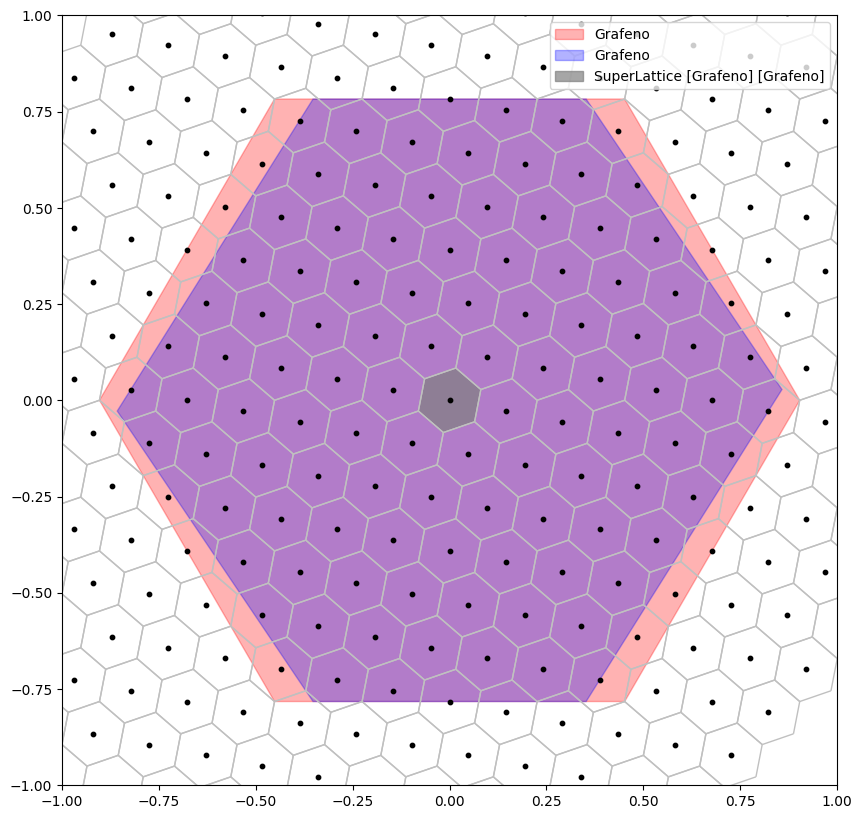

In [12]:
ax = plt.subplot()
hexa1=Polygon(a,alpha=0.3, color = 'red', label = m1.name)
ax.add_patch(hexa1)
hexa2=Polygon(a2,alpha=0.3, color = 'blue', label = m2.name)
ax.add_patch(hexa2)
hexa3=Polygon(a3,alpha=0.7, color = 'gray', label = m3.name)
ax.add_patch(hexa3)
ax.add_collection(le)
ax.scatter(xs,ys, color='black',s=t)
ax.set(xlim=(-1,1), ylim=(-1,1))
ax.legend(loc = 'upper right')
plt.show()

In [14]:
a,a2,a3

([(0.4291793243, 0.7433603952),
  (-0.4291793243, 0.7433603952),
  (-0.8583586485, 0.0),
  (-0.4291793243, -0.7433603952),
  (0.4291793243, -0.7433603952),
  (0.8583586485, 0.0)],
 [(0.4291793243, 0.7433603952),
  (-0.4291793243, 0.7433603952),
  (-0.8583586485, 0.0),
  (-0.4291793243, -0.7433603952),
  (0.4291793243, -0.7433603952),
  (0.8583586485, 0.0)],
 [(0.0806728053, 0.0279458795),
  (0.0161345611, 0.0838376386),
  (-0.0645382442, 0.055891759),
  (-0.0806728053, -0.0279458795),
  (-0.0161345611, -0.0838376386),
  (0.0645382442, -0.055891759)])

In [21]:
enls

[[(-0.9574000310609554, 1.0864498082968588),
  (-1.0234276193609555, 1.3151760837968587)],
 [(-1.0234276193609555, 1.3151760837968587),
  (-1.2545241785609553, 1.3723576525968588)],
 [(-1.2545241785609553, 1.3723576525968588),
  (-1.4195931494609555, 1.2008129460968586)],
 [(-1.4195931494609555, 1.2008129460968586),
  (-1.3535655611609554, 0.9720866705968587)],
 [(-1.3535655611609554, 0.9720866705968587),
  (-1.1224690019609556, 0.9149051017968587)],
 [(-1.1224690019609556, 0.9149051017968587),
  (-0.9574000310609554, 1.0864498082968588)],
 [(-1.0564414135827018, 0.686178826277958),
  (-1.122469001882702, 0.914905101777958)],
 [(-1.122469001882702, 0.914905101777958),
  (-1.3535655610827018, 0.9720866705779581)],
 [(-1.3535655610827018, 0.9720866705779581),
  (-1.518634531982702, 0.8005419640779581)],
 [(-1.518634531982702, 0.8005419640779581),
  (-1.4526069436827018, 0.5718156885779581)],
 [(-1.4526069436827018, 0.5718156885779581),
  (-1.221510384482702, 0.514634119777958)],
 [(-1.22

In [33]:
m2.name

'Grafeno(rot 32.2°)'

In [3]:
atomos=[Atomo((0.333333343,0.666666687),posZ=0.500000000,color='Red',sig='Cd'),
        Atomo((0.666666627,0.333333313),posZ=0.250000000,color='Red',sig='Cd'),
        Atomo((0.333333343,0.666666687),posZ=0.1899999975,color='gold',sig='S'),
        Atomo((0.666666627,0.333333313),posZ=0.4399999975,color='gold',sig='S')]
CdS=Red((4.2100000381,0.0000000000),(-2.1050000191,3.6459669830),atms=atomos, detachment=13.6800003052 ,name='CdS')

atmsG=[Atomo((0.000000000,0.000000000)),Atomo((0.333333343,0.666666687))]
grafeno=Red((2.4410462379,0.0000000000),(-1.2205231190,2.1140080539),atms=atmsG,name='Grafeno')

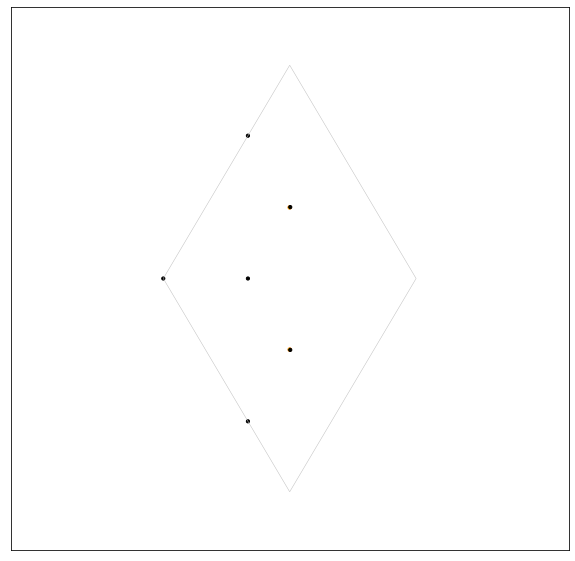

In [4]:
gR=grafeno.mRot(30)
sA,sB=m2V(CdS.a,CdS.b,(0,-1)),m2V(CdS.a,CdS.b,(1,1))
sR=superMesh(sA,sB,[CdS,gR])
sR.showme()

	0.58	-0.58	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0
	0.34	0.34	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.5
	1.0	-1.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.74
	2.0	-1.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	2.97
	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	1.48
	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	1.48
	-1.0	1.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.74
	-2.0	1.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	1.48

	0.39	-0.19	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.43
	-0.0	0.34	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.74
	1.0	-1.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	2.21
	2.0	-1.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	8.83
	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	4.42
	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	4.42
	-1.0	1.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	2.21
	-2.0	1.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	4.42

	0.34	0.0	0.0	0.0	0.0	0.0	0.34	0.0	1.0	0.0	0.5
	-1.0	1.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.74
	0.0	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	1.48
	1.0	0.0	0.0	1.0	0.0	0.0	1.0	0.0	0.0	0.0	3.71
	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	1.48
	1.0	0.0	0.0	0

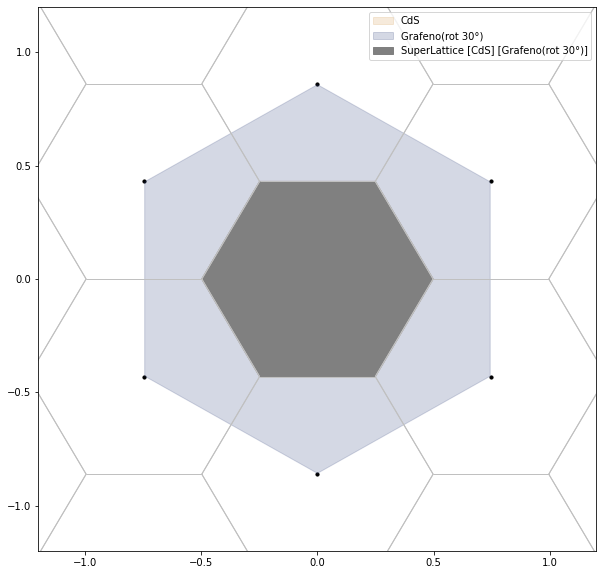

In [5]:
pReciprocal(sR,[CdS,gR])

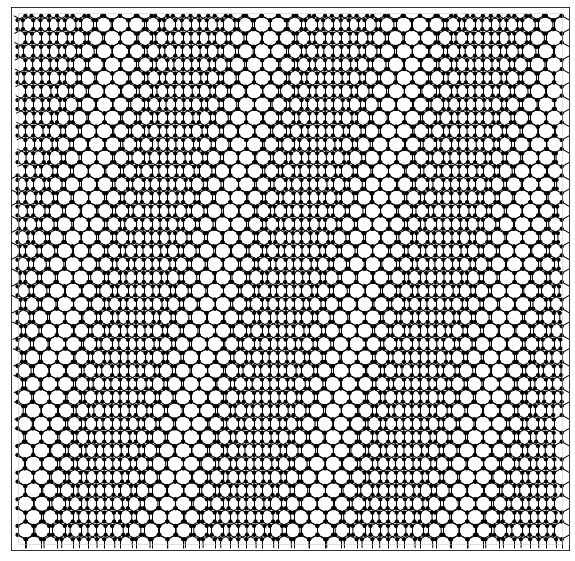

In [27]:
g1=grafeno()
g2=grafeno()
g1.setNewVectors((2.318, 0),(-1.1589999999999996, 2.007446885972329))
g1.name="Grafeno(-5%)"
g2.setNewVectors((-2.5961600000000002, 0.0),(1.2517200000000006, 2.007446885972329))
g2.name="Grafeno(-3%,+6.3%)"
superMesh((80,0),(0,80),[g1,g2]).showme()

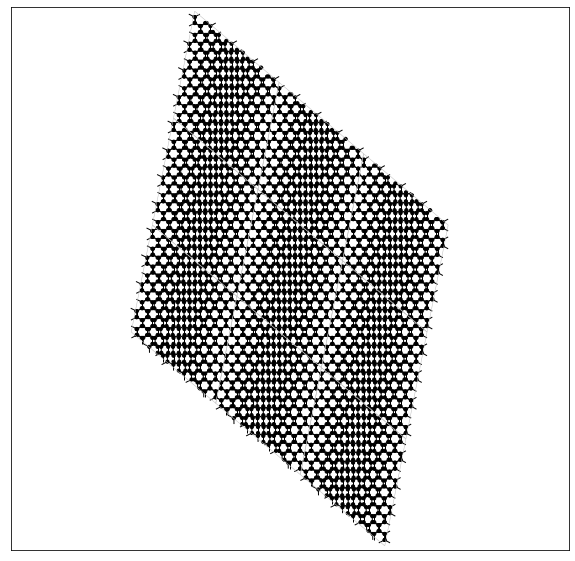

1

In [28]:
g3=superMesh((18.543999999999997, -16.059575087778633),(4.636000000000006, 24.08936263166795),[g1,g2])
g3.showXY(3,3)

Calculando...
...Pintando capa 1
...Pintando capa 2
...Terminado


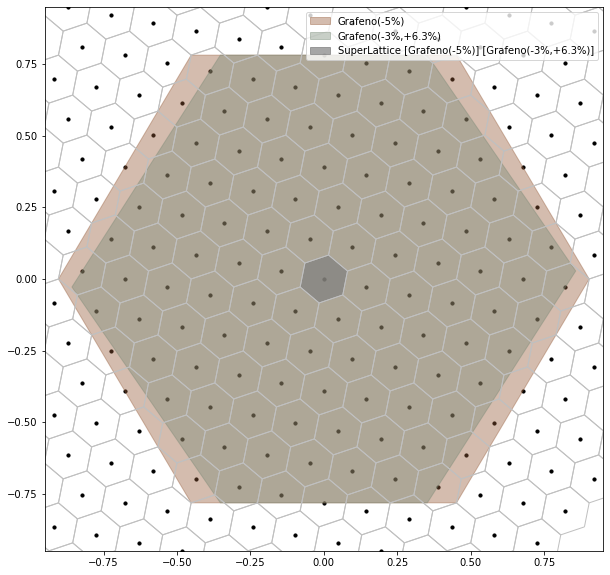

In [36]:
pReciprocal(g3,[g1,g2],border=0.95)